<h1><center> <ins><b> K-Means Clustering Visualisation Code </b></ins></center></h1>

For the purposes of visualising this algorithm, we will strictly be working with 2-dimensional datasets in order to make plotting easier.

We will use 4 datasets to see how our algorithm works and they will be:
1) Dataset made of a random sample from multivariate normal distributions with 4 easily identifiable clusters\
2) Dataset made of a random sample from one multivariate normal distribution with unknown number of clusters\
3) Real Data from Dow Jones Industrial Average (DJIA) returns and volatility\
4) Real Data from S&P500 stocks' RSI and ATR (14 day window)

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import pandas_ta
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import random
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import sklearn.cluster as cluster
import sklearn.metrics as metrics
from scipy import stats
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import datetime as dt
import yfinance as yf

In [2]:
# This function returns the euclidean distance between 2 points. We define it here to avoid having to write it everywhere below
def distance(p1,p2):
    return np.sqrt(np.sum((p1 - p2)**2))

In [3]:
# Plotting Elbow Graph
def ElbowGraph(data):

    cs = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
        kmeans.fit(data)
        cs.append(kmeans.inertia_)

    plt.figure(figsize=(12,8))
    plt.plot(range(1, 11), cs)
    plt.title('Elbow Graph', fontsize = 30)
    plt.xlabel('Number of clusters', fontsize = 25)
    plt.ylabel('WCSS', fontsize = 25)
    plt.show()
    return

In [4]:
# Calculating Silhouette Scores
def SilhouetteScore(data):
    
    SK = range(2,11)
    sil_score = []
    for i in SK:
        labels=cluster.KMeans(n_clusters=i,init="k-means++",n_init='auto',random_state=0).fit(data).labels_
        score = metrics.silhouette_score(data,labels,metric="euclidean",sample_size=1000,random_state=0)
        sil_score.append(score)
        print("Silhouette score for k = " +str(i)+ " is", "%.5f" % round(sil_score[i-2], 5))
    return

In [5]:
# This function will help us visualise the process of the centroids being chosen out of all datapoints
def CentroidPlot(data, centroids):
    
    # Plot all datapoints
    plt.figure(figsize=(12,8))
    plt.scatter(data.iloc[:,:1], data.iloc[:,1:2], marker='o',
                color='gray', label='Data Points')
    # Plot the old centroids already defined
    plt.scatter(centroids[:-1, 0], centroids[:-1, 1],
                color='black', label='Previous Centroids', s=100)
    # Plot the new centroid that has just been defined
    plt.scatter(centroids[-1, 0], centroids[-1, 1],
                color='red', label='Current Centroid', s=100)
    
    # Adjustments to plot
    plt.xlabel(data.columns[0], fontsize=25)
    plt.ylabel(data.columns[1], fontsize=25)
    plt.title('Selecting centroid %d' % (centroids.shape[0]), fontsize=30)
    plt.legend()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.show()
    return

In [6]:
# This function will initialise our first set of centroids through a K-Means++ implementation
def InitCentroids(data,k):
    
    # Seed for reproducibility of results
    random.seed(0)
    
    # Initialise our array of centroids
    centroids = []
    # We will take our first centroid to be any random datapoint within our dataframe ***ILOC CHANGE HERE***
    centroids.append(data.iloc[random.randint(0,len(data)+1), :2].to_numpy())
    # Call our plot function
    CentroidPlot(data, np.array(centroids))
    
    # CHANGE INTO 2D ARRAY SINCE WE DO NOT NEED TO TABULATE/DISPLAY DISTANCES
    # We will make a dataframe to store distances of points from centroids so we can call from it instead of calculating each distance every time
    distances = pd.DataFrame()
    
    for a in range(k-1):
        # Initialise and store all distances from all points to a centroid
        d=[]
        for i in range(len(data)):
            d.append(distance(np.array(data.iloc[i, :2]),centroids[a]))
        distances[f'd{a+1}'] = d
        
        # Here we isolate the case where we only have 1 predefined centroid since we do not need to take the minimum of multiple distances
        if a == 0:
            # Find our constant in our weighted probability distribution (explained in previous notebook)
            c = 1/(np.sum(distances['d1']**2))
            w = c*(distances['d1']**2)
            # Use this weighted probability distribution to choose the next centroid
            temp = int(random.choices(population=np.linspace(0,len(data)-1,len(data)),weights=w,k=1)[0])
            centroids.append(np.array(data.iloc[temp,:2]))
            # Call our initial centroid plotting function
            CentroidPlot(data.iloc[:,:2], np.array(centroids))
        
        # Here we deal with the case where we have multiple predefined centroids
        else:
            # Take the minimum of all distances
            distances['mins'] = distances[list(distances.columns)].min(axis=1)
            # Find our constant in our weighted probability distribution (explained in previous notebook)
            c = 1/(np.sum(distances['mins']**2))
            w = c*(distances['mins']**2)
            # Use this weighted probability distribution to choose the next centroid
            temp = int(random.choices(population=np.linspace(0,len(data)-1,len(data)),weights=w,k=1)[0])
            centroids.append(np.array(data.iloc[temp,:2]))
            # Drop the minimum distance column so it does not affect future calculations
            distances.drop(['mins'],axis=1,inplace=True)
            # Call our initial centroid plotting function
            CentroidPlot(data.iloc[:,:2], np.array(centroids))
    
    # We can quickly sort our centroids by their y-values or however we want to sort our cluster order in the future
    centroids = sorted(centroids, reverse=True, key=lambda k: k[1])

    return centroids

In [7]:
# This function will perform the K-Means Algorithm and assign each data point a cluster
def KMeansCluster(data, centroids, k):
    
    # Initialize clusters list
    clusters = [[] for _ in range(k)]
    
    # Loop until convergence
    # Initialise our current iteration and maximum iterative value
    max_iter = 50
    iteration = 0
    # Initialise our old centroids so we can check for equality in our while statement
    old_centroids = [[0]*2 for _ in range(k)]
    while np.any(np.not_equal(centroids,old_centroids)) and iteration < max_iter:

        # Clear previous clusters and initiliase array to store cluster values
        clusters = [[] for _ in range(k)]
        temptemp=[]
        
        # Assign each point to the closest centroid and store which cluster it belongs to
        for point in np.array(data.iloc[:,:2]):
            distances_to_each_centroid = [distance(point, centroid) for centroid in centroids]
            cluster_assignment = np.argmin(distances_to_each_centroid)
            temptemp.append(cluster_assignment)
            clusters[cluster_assignment].append(point)
        
        # Assign old centroids as centroids for comparison in our while statement
        old_centroids = centroids
        # Calculate new centroids by taking the mean of all points within a respective cluster
        new_centroids = [np.array(np.mean(cluster,axis=0)) for cluster in clusters]
        # Assign centroids as these new centroids
        centroids = new_centroids
        # Increase iteration by 1
        iteration += 1
    
    # Write the corresponding cluster for each datapoint in our dataframe
    data['cluster'] = temptemp
    print('The centroids are', np.array(centroids).tolist())
    print('\nResults achieved on iteration', iteration)
    return centroids

In [8]:
# This function will plot our Voronoi Diagram
def VoronoiPlot(data, centroids, k):
    
    # Add outlier points to our centroids so we can colour our plot easier in the future
    centroids2 = np.append(centroids, [[999,999], [-999,999], [999,-999], [-999,-999]], axis=0)
    
    # Plot inital voronoi diagram
    vor = Voronoi(centroids2)
    fig,ax = plt.subplots(1,1,figsize=(12, 8))
    voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False)

    # We will remove the extra regions that we do not need
    regions=[]
    for region in vor.regions:
        if not -1 in region:
            regions.append(region)
    regions = [x for x in regions if x != []]

    # When running the initial voronoi diagram, the regions are not in the same order as our centroids
    # So we will find which regions our centroid are in and order our regions correctly at the end
    order=[]
    for i in range(k):
        for j in range(k):
            point = Point(centroids[i])
            shape = Polygon([vor.vertices[v] for v in regions[j]])
            if shape.contains(point) == True:
                break
        order.append(j)
    regions = [regions[i] for i in order]

    # Colour the regions for easy visualisation
    color = list(cm.rainbow(np.linspace(0, 1, k)))
    for a,region in enumerate(regions):
        polygon = [vor.vertices[i] for i in region]
        ax.fill(*zip(*polygon),color=color[a],alpha=0.25)
    
    # Plot the datapoints with varying colours based on which cluster it belongs to
    for i in range(k):
        ax.scatter(data[data['cluster']==i].iloc[:,:1], data[data['cluster']==i].iloc[:,1:2], marker='o',
                    color=color[i], edgecolors='black', label=f'points for cluster {i}', s=30)
    # Plot the centroids
    ax.scatter(np.array(centroids)[:, 0], np.array(centroids)[:, 1], marker='X',
                color='black', edgecolors='black', label='centroids', s=100)
    
    # Last touches to our plot
    plt.xlabel(data.columns[0], fontsize=18)
    plt.ylabel(data.columns[1], fontsize=18)
    plt.title('Visualising our K-Means Clustering Algorithm', fontsize=25)
    plt.legend()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.show()
    return

<h1><center> <ins><b> Dataset 1 </b></ins></center></h1>

In [9]:
# Creating data
np.random.seed(0)
mean_01 = [0.0, 0.0]
cov_01 = [[1, 0.3], [0.3, 1]]
dist_01 = np.random.multivariate_normal(mean_01, cov_01, 250)

mean_02 = [6.0, 7.0]
cov_02 = [[1.5, 0.3], [0.3, 1]]
dist_02 = np.random.multivariate_normal(mean_02, cov_02, 250)

mean_03 = [7.5, -5.0]
cov_03 = [[0.8, 0.5], [0.5, 1]]
dist_03 = np.random.multivariate_normal(mean_03, cov_01, 250)

mean_04 = [1.0, -7.0]
cov_04 = [[1.0, 0.5], [0.5, 1.3]]
dist_04 = np.random.multivariate_normal(mean_04, cov_01, 250)

data = np.vstack((dist_01, dist_02, dist_03, dist_04))
np.random.shuffle(data)
data = pd.DataFrame(data)
data.rename(columns={0: 'x', 1: 'y'}, inplace=True)
#data.to_csv('/Users/Sajeeth/Documents/Quant Portfolio/Machine Learning Projects/K-Means Clustering/Data.csv', encoding='utf-8', index=False, header=True)
data

,x,y
0,1.685464,0.005276
1,-1.658961,-1.185488
2,0.679986,-5.880540
3,4.178174,4.497586
4,2.560494,-7.381996
...,...,...
995,6.337033,6.055192
996,3.781123,4.651209
997,7.630637,-6.109575
998,5.961079,-6.091951


In [10]:
# Find the min and max values of each column for our plots later
xmin = data.iloc[:,:1].describe().iloc[3][0]
xmax = data.iloc[:,:1].describe().iloc[7][0]
ymin = data.iloc[:,1:2].describe().iloc[3][0]
ymax = data.iloc[:,1:2].describe().iloc[7][0]
xmin,ymin = (np.floor(x)-1 for x in (xmin,ymin))
xmax,ymax = (np.ceil(x)+1 for x in (xmax,ymax))

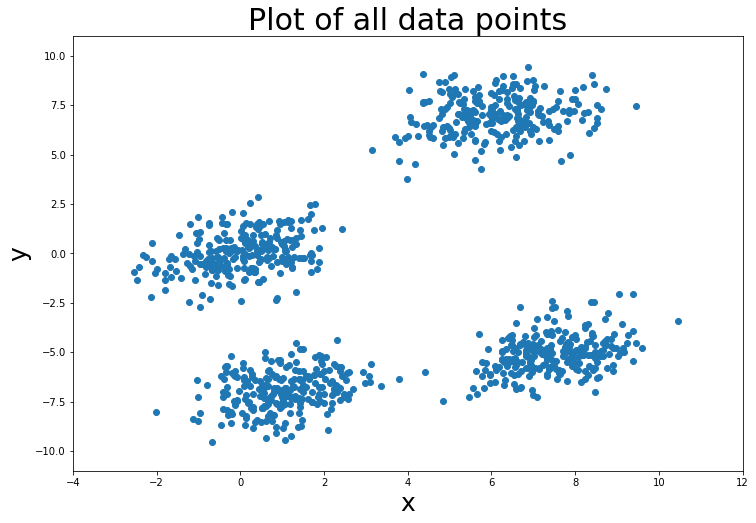

In [11]:
# Plot the data to see what we are working with
plt.figure(figsize=(12,8))
plt.scatter(data.iloc[:,:1], data.iloc[:,1:2], cmap='viridis', marker='o')
plt.xlabel(data.columns[0], fontsize=25)
plt.ylabel(data.columns[1], fontsize=25)
plt.title('Plot of all data points', fontsize=30)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

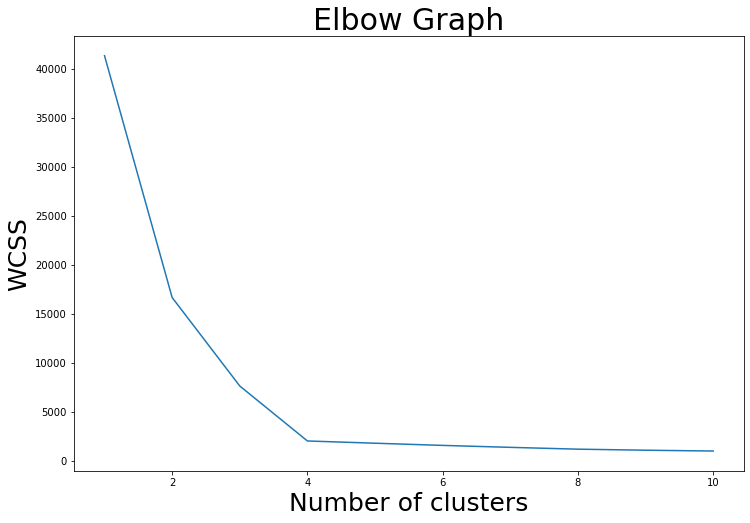

In [12]:
# Plotting Elbow Graph
ElbowGraph(data)

In [13]:
# Calculating Silhouette Scores
SilhouetteScore(data)

Silhouette score for k = 2 is 0.58397
Silhouette score for k = 3 is 0.62425
Silhouette score for k = 4 is 0.75172
Silhouette score for k = 5 is 0.64035
Silhouette score for k = 6 is 0.54039
Silhouette score for k = 7 is 0.53240
Silhouette score for k = 8 is 0.44642
Silhouette score for k = 9 is 0.36572
Silhouette score for k = 10 is 0.35780


## Clearly, looking at the plot of all data points by eye, there are 4 clusters. This is further supported by our Elbow Graph which has an elbow at k=4 and also by our Silhouette Scores, where k=4 has the highest score of ~0.752. <br>Thus, let us continue with k=4

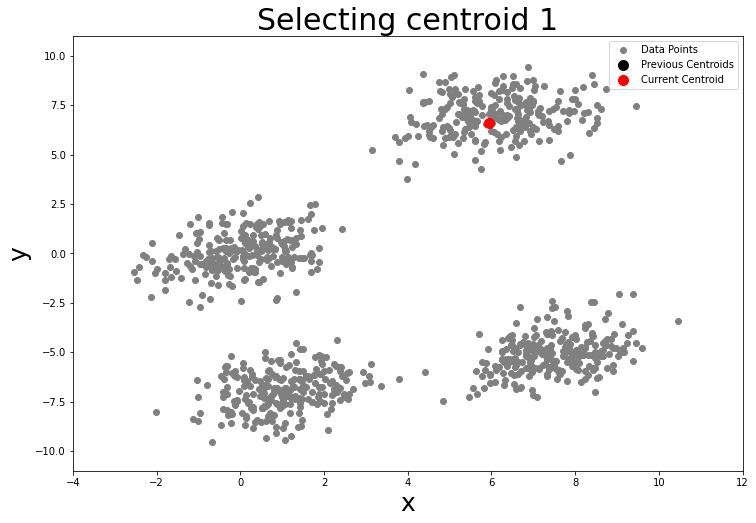

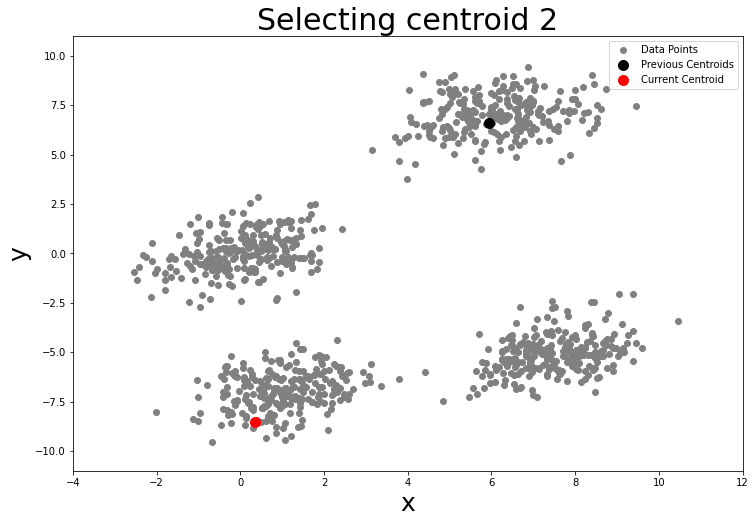

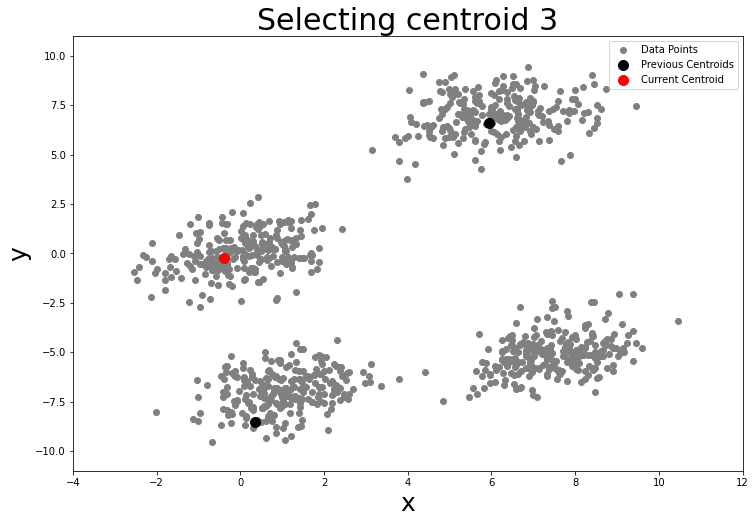

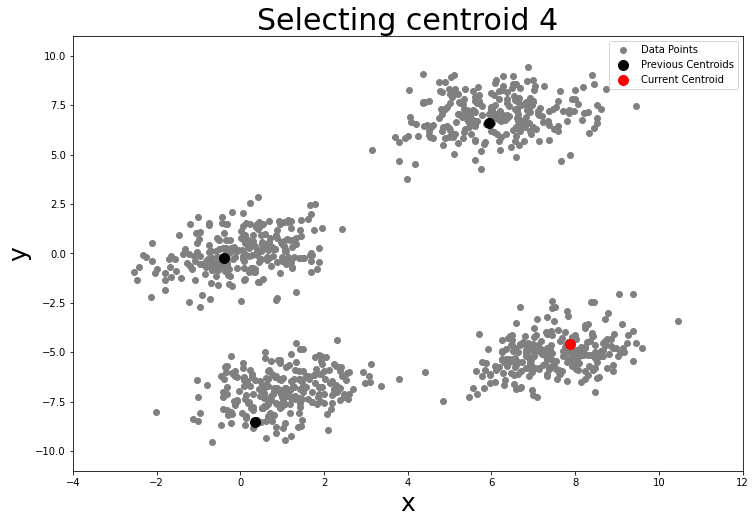

In [14]:
# Initialising centroids
centroids = InitCentroids(data,4)

In [15]:
# Performing K-Means Clustering
centroids2 = KMeansCluster(data,centroids,4)

The centroids are [[6.110504815651851, 6.997476262162707], [0.041468145587098805, 0.04469520477329504], [7.44713023710177, -5.084796293215528], [1.0112490664052882, -6.9441849087356]]

Results achieved on iteration 2


## Now, we will plot our Voronoi Diagram with our initial set of centroids

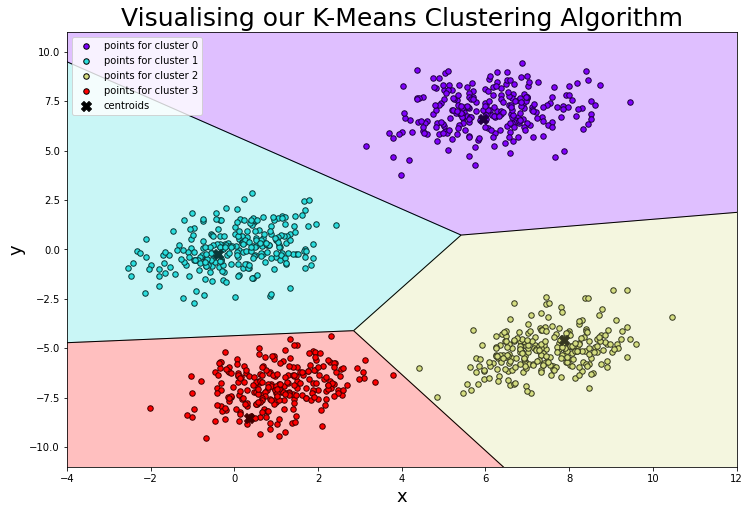

In [16]:
VoronoiPlot(data,centroids,4)

## To compare, we will now plot our Voronoi Diagram with our final set of centroids

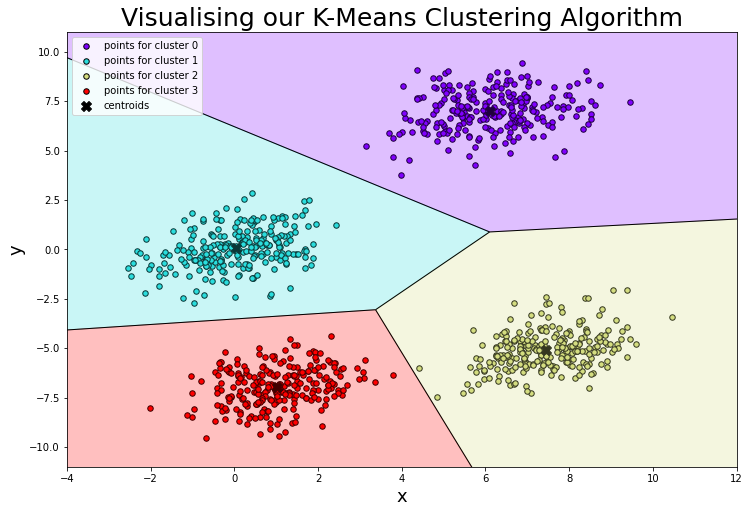

In [17]:
VoronoiPlot(data,centroids2,4)

## Finally, let us see our clustered data

In [18]:
data

,x,y,cluster
0,1.685464,0.005276,1
1,-1.658961,-1.185488,1
2,0.679986,-5.880540,3
3,4.178174,4.497586,0
4,2.560494,-7.381996,3
...,...,...,...
995,6.337033,6.055192,0
996,3.781123,4.651209,0
997,7.630637,-6.109575,2
998,5.961079,-6.091951,2


In [19]:
# Print how many data points are in each cluster
number = []
for i in range(4):
    number.append(len(data[data['cluster']==i]))
    print("There are",number[i],f"data points in cluster {i}")

There are 250 data points in cluster 0
There are 250 data points in cluster 1
There are 250 data points in cluster 2
There are 250 data points in cluster 3


<h1><center> <ins><b> Dataset 2 - Unknown number of clusters </b></ins></center></h1>

In [20]:
# Creating data
np.random.seed(9)
mean_01 = [0.0, 0.0]
cov_01 = [[1, 0.3], [0.3, 1]]
dist_01 = np.random.multivariate_normal(mean_01, cov_01, 1000)

np.random.shuffle(dist_01)
data = pd.DataFrame(dist_01)
data.rename(columns={0: 'x', 1: 'y'}, inplace=True)
#data.to_csv('/Users/Sajeeth/Documents/Quant Portfolio/Machine Learning Projects/K-Means Clustering/Data.csv', encoding='utf-8', index=False, header=True)
data

,x,y
0,-1.302311,0.661477
1,-0.903378,0.917757
2,0.674407,0.704603
3,0.265943,-0.565225
4,-0.384121,-0.603867
...,...,...
995,1.552363,-0.198451
996,-1.160200,0.352182
997,1.319840,0.001700
998,-1.217116,-1.142280


In [21]:
# Find the min and max values of each column for our plots later
xmin = data.iloc[:,:1].describe().iloc[3][0]
xmax = data.iloc[:,:1].describe().iloc[7][0]
ymin = data.iloc[:,1:2].describe().iloc[3][0]
ymax = data.iloc[:,1:2].describe().iloc[7][0]
xmin,ymin = (np.floor(x)-1 for x in (xmin,ymin))
xmax,ymax = (np.ceil(x)+1 for x in (xmax,ymax))

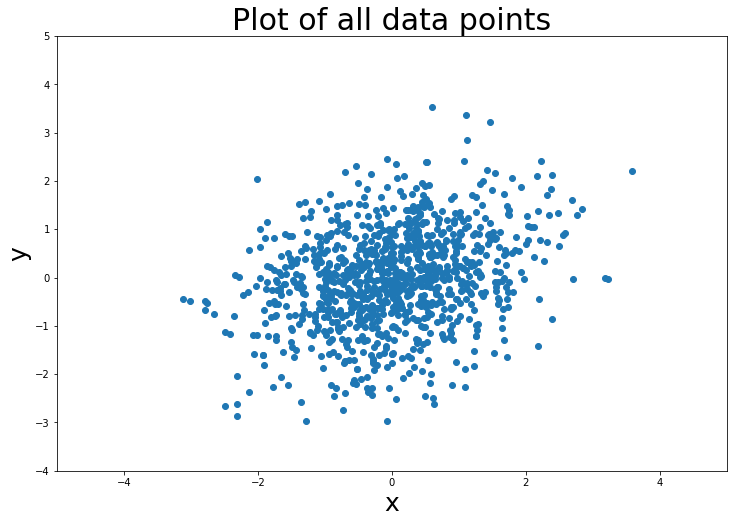

In [22]:
# Plot the data to see what we are working with
plt.figure(figsize=(12,8))
plt.scatter(data.iloc[:,:1], data.iloc[:,1:2], cmap='viridis', marker='o')
plt.xlabel(data.columns[0], fontsize=25)
plt.ylabel(data.columns[1], fontsize=25)
plt.title('Plot of all data points', fontsize=30)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

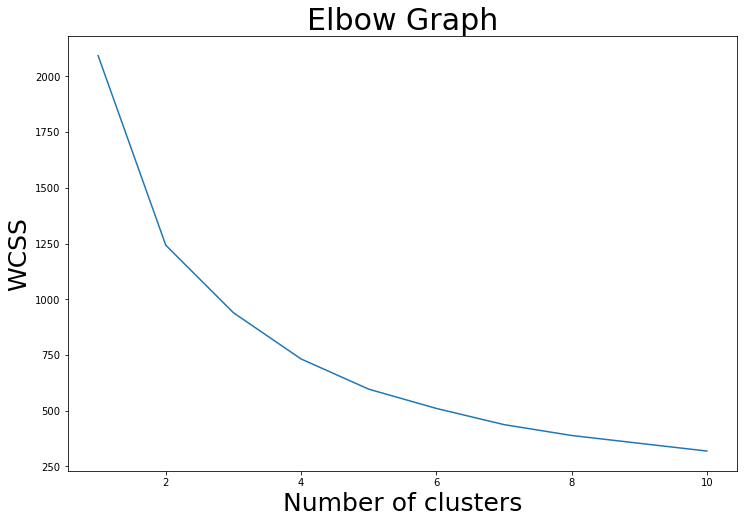

In [23]:
# Plotting Elbow Graph
ElbowGraph(data)

In [24]:
# Calculating Silhouette Scores
SilhouetteScore(data)

Silhouette score for k = 2 is 0.35546
Silhouette score for k = 3 is 0.32348
Silhouette score for k = 4 is 0.31442
Silhouette score for k = 5 is 0.30108
Silhouette score for k = 6 is 0.31577
Silhouette score for k = 7 is 0.31055
Silhouette score for k = 8 is 0.32418
Silhouette score for k = 9 is 0.32736
Silhouette score for k = 10 is 0.31920


## It is hard to tell solely by the initial plot of all data points or the elbow graph, how many clusters there are. Although we achieve the highest Silhouette Score at k=2, for the sake of curiosity and to see if our code works with high values of k, let us take k=10.

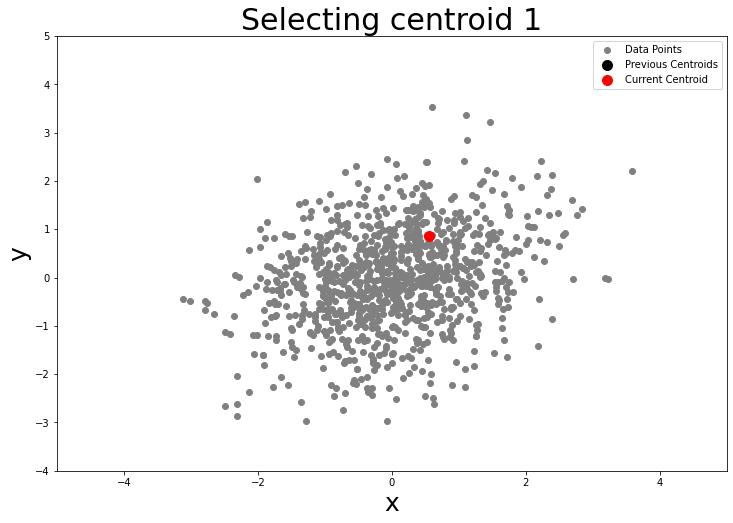

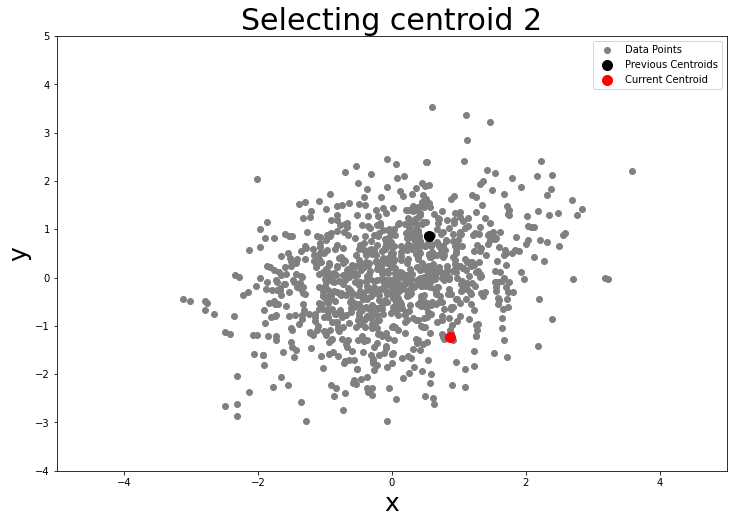

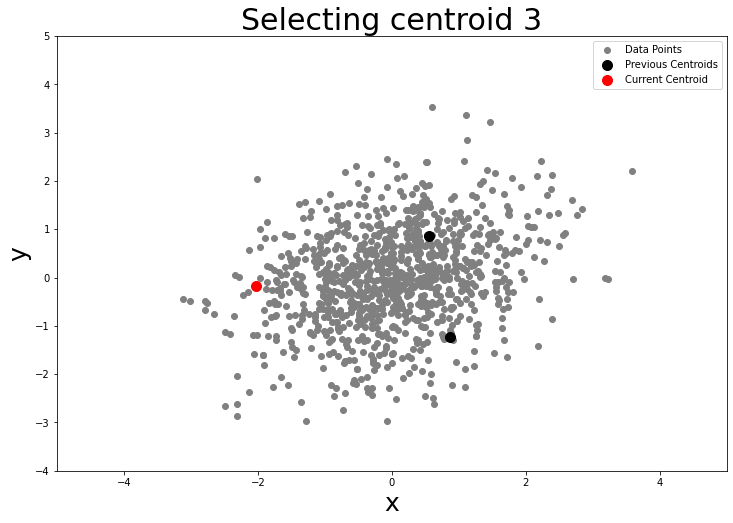

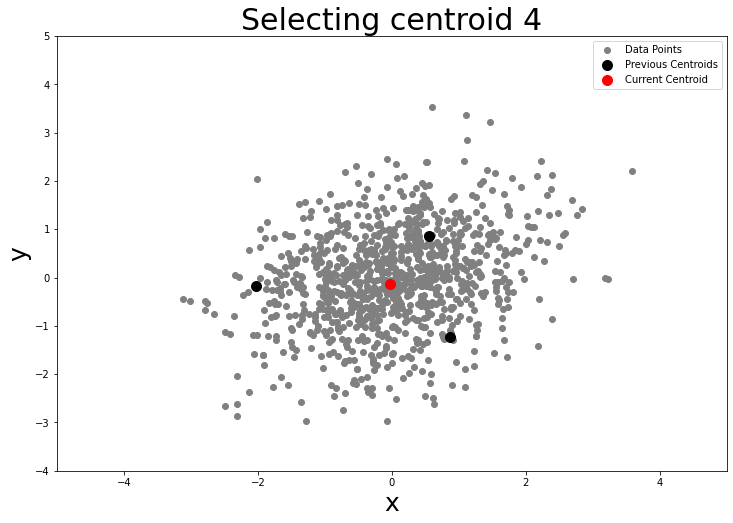

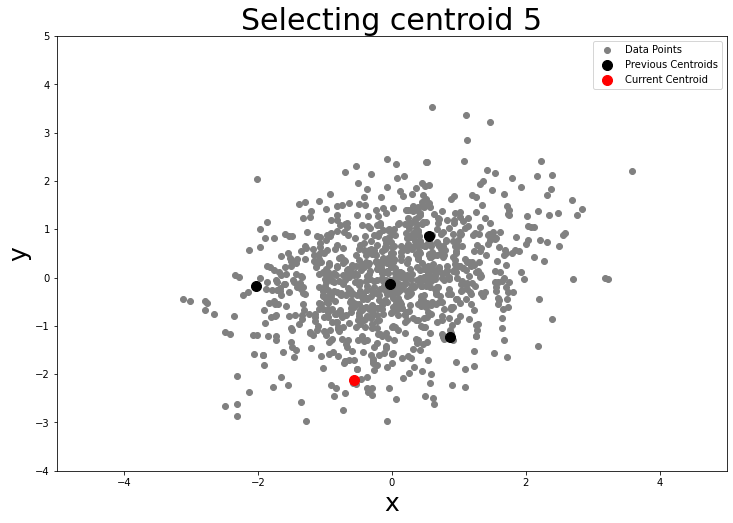

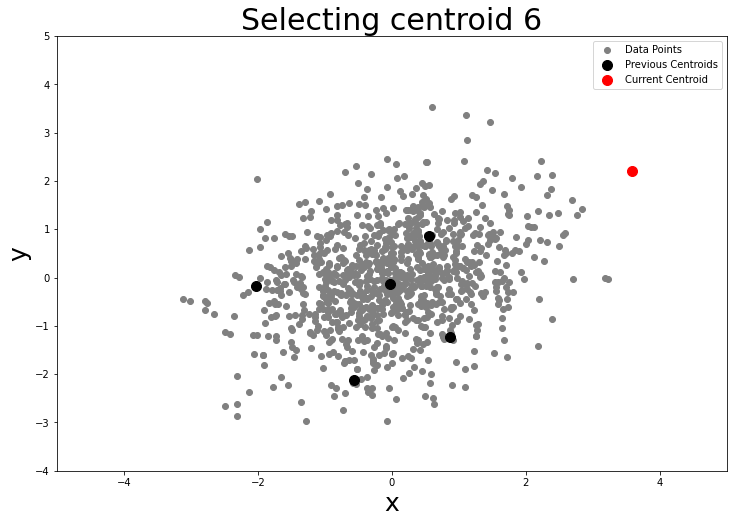

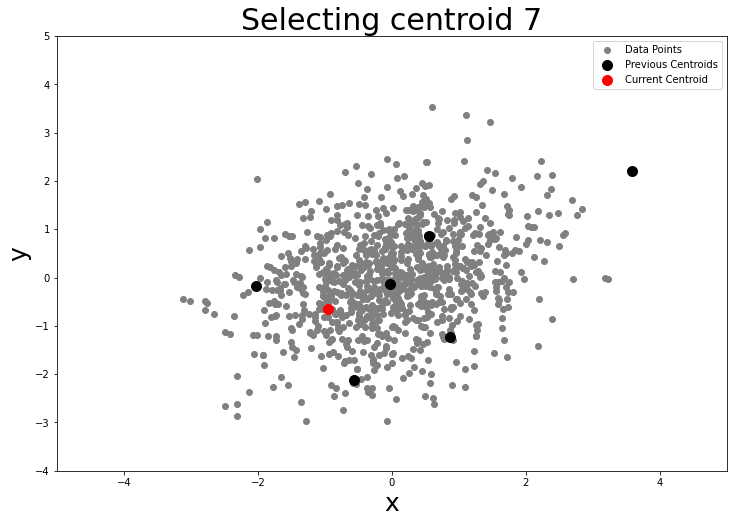

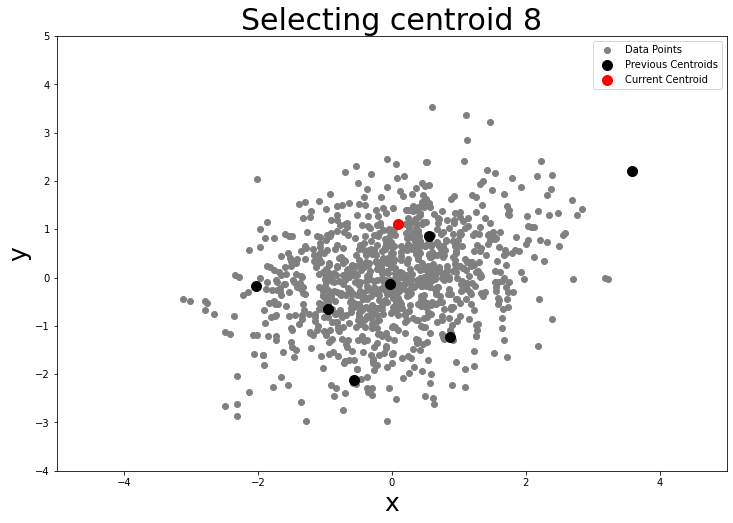

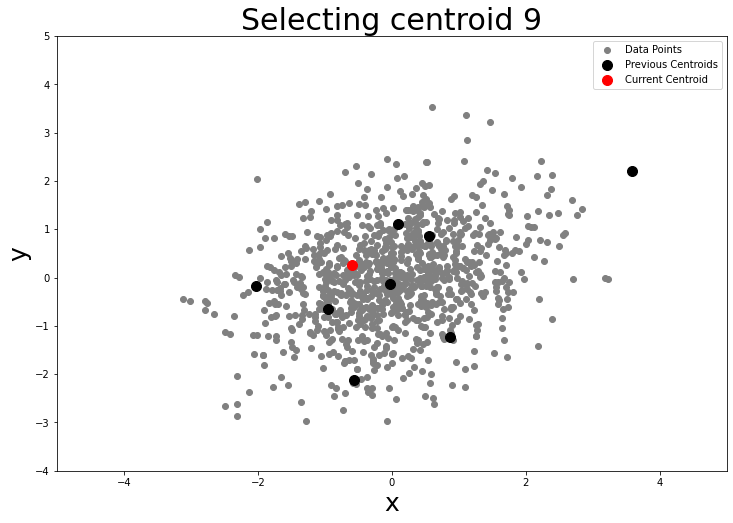

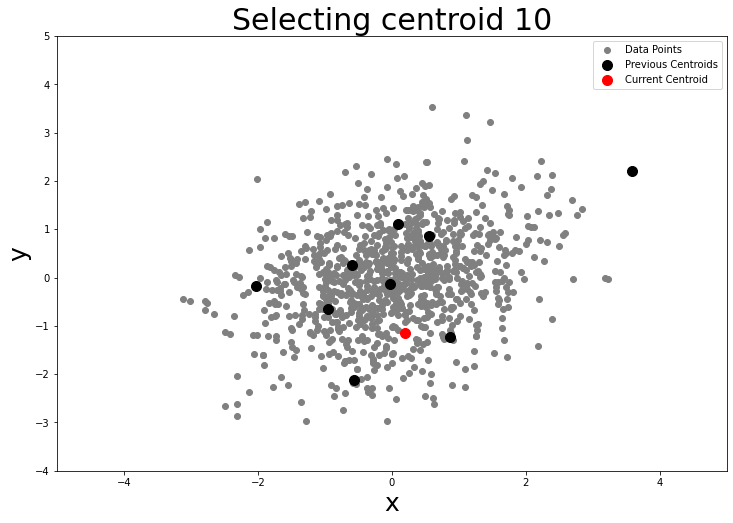

In [25]:
# Initialising centroids
centroids = InitCentroids(data,10)

In [26]:
# Performing K-Means Clustering
centroids2 = KMeansCluster(data,centroids,10)

The centroids are [[1.9372499904122764, 1.2221027512549456], [0.14174754398451217, 1.5309886767620908], [0.7103473967196358, 0.627258732983889], [-0.9427638917733656, 0.5980752924340954], [0.11781776517119888, -0.09168182482752243], [-1.810704432559849, -0.4255415308556275], [-0.6814423291718047, -0.6433064914899114], [0.28636036050801095, -1.4682214406136411], [1.3173355540934868, -0.4311779006435077], [-1.096106499148571, -2.00412152147532]]

Results achieved on iteration 24


## Now, we will plot our Voronoi Diagram with our initial set of centroids

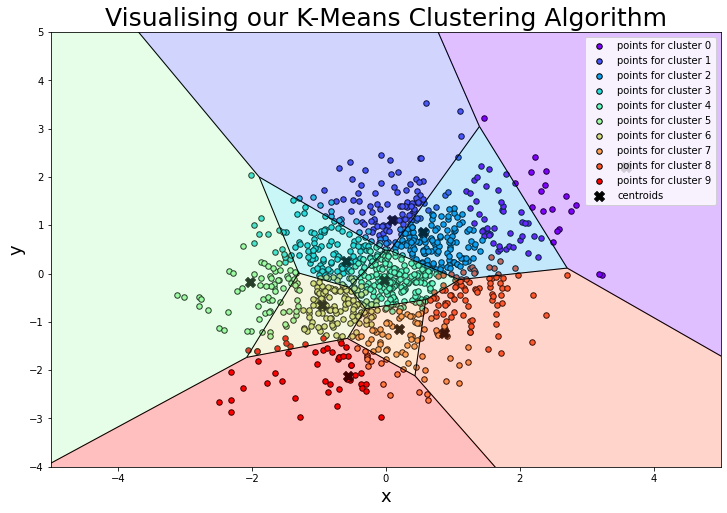

In [27]:
VoronoiPlot(data,centroids,10)

## To compare, we will now plot our Voronoi Diagram with our final set of centroids

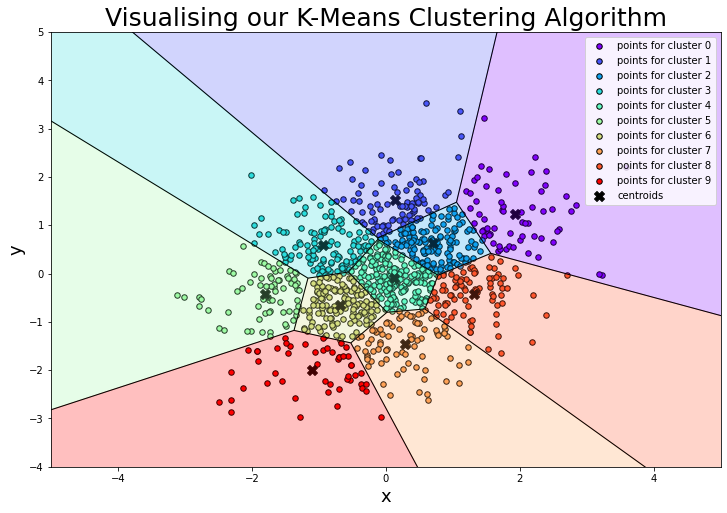

In [28]:
VoronoiPlot(data,centroids2,10)

## Finally, let us see our clustered data

In [29]:
data

,x,y,cluster
0,-1.302311,0.661477,3
1,-0.903378,0.917757,3
2,0.674407,0.704603,2
3,0.265943,-0.565225,4
4,-0.384121,-0.603867,6
...,...,...,...
995,1.552363,-0.198451,8
996,-1.160200,0.352182,3
997,1.319840,0.001700,8
998,-1.217116,-1.142280,6


In [30]:
# Print how many data points are in each cluster
number = []
for i in range(10):
    number.append(len(data[data['cluster']==i]))
    print("There are",number[i],f"data points in cluster {i}")

There are 63 data points in cluster 0
There are 87 data points in cluster 1
There are 136 data points in cluster 2
There are 115 data points in cluster 3
There are 178 data points in cluster 4
There are 70 data points in cluster 5
There are 136 data points in cluster 6
There are 81 data points in cluster 7
There are 84 data points in cluster 8
There are 50 data points in cluster 9


<h1><center> <ins><b> Dataset 3 - Real DJIA Data</b></ins></center></h1>

In [31]:
# Call DJIA stock data and calculate returns and volatility
temp = pd.read_html("https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average")[2]
temp['Symbol'] = temp['Symbol'].str.replace('.', '-')
symbols_list = temp['Symbol'].unique().tolist()
# Declare dates
end_date = '2024-07-30'
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)
# Get stock data
df = yf.download(tickers=symbols_list,
                 auto_adjust=False,
                 start=start_date,
                 end=end_date)
df = df['Adj Close']
# Calculate returns and volatility
data = (df
        .pct_change()
        .describe()
        .T[["mean", "std"]]
        .rename(columns={"mean": "returns", "std": "vol"})
        ) * [252, np.sqrt(252)]
# Removing extreme outliers
data = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]
data

[*********************100%***********************]  30 of 30 completed


,returns,vol
Ticker,,
AAPL,0.317630,0.291758
AMGN,0.140286,0.243428
AMZN,0.248985,0.325859
AXP,0.235571,0.323047
BA,0.145530,0.430039
CAT,0.250569,0.303059
CRM,0.208482,0.353967
CSCO,0.119798,0.254593
CVX,0.146264,0.303783


In [32]:
# Find the min and max values of each column for our plots later
xmin = data.iloc[:,:1].describe().iloc[3][0]
xmax = data.iloc[:,:1].describe().iloc[7][0]
ymin = data.iloc[:,1:2].describe().iloc[3][0]
ymax = data.iloc[:,1:2].describe().iloc[7][0]
xmin,ymin = (round(x-0.1,1) for x in (xmin,ymin))
xmax,ymax = (round(x+0.1,1) for x in (xmax,ymax))

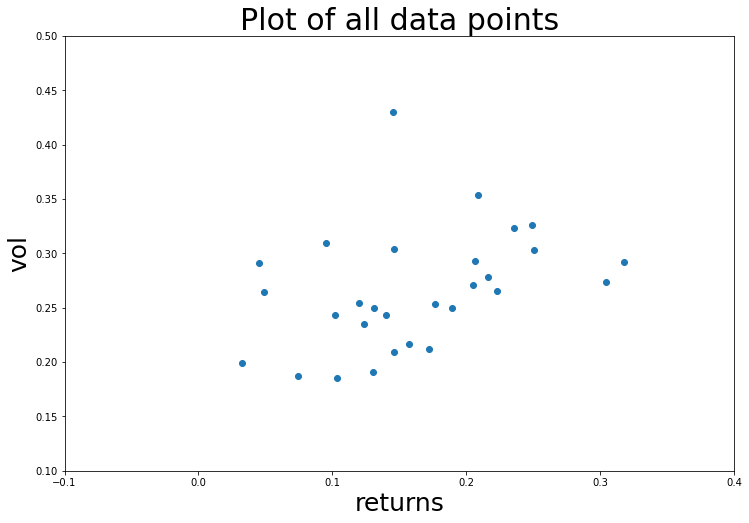

In [33]:
# Plot the data to see what we are working with
plt.figure(figsize=(12,8))
plt.scatter(data.iloc[:,:1], data.iloc[:,1:2], cmap='viridis', marker='o')
plt.xlabel(data.columns[0], fontsize=25)
plt.ylabel(data.columns[1], fontsize=25)
plt.title('Plot of all data points', fontsize=30)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

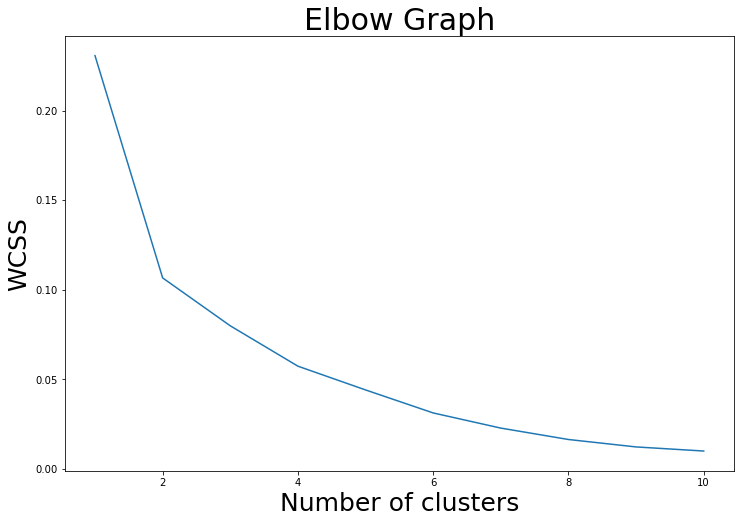

In [34]:
# Plotting Elbow Graph
ElbowGraph(data)

In [35]:
# Calculating Silhouette Scores
SilhouetteScore(data)

Silhouette score for k = 2 is 0.44219
Silhouette score for k = 3 is 0.41312
Silhouette score for k = 4 is 0.25607
Silhouette score for k = 5 is 0.23414
Silhouette score for k = 6 is 0.30140
Silhouette score for k = 7 is 0.33873
Silhouette score for k = 8 is 0.40435
Silhouette score for k = 9 is 0.43590
Silhouette score for k = 10 is 0.34330


## It is hard to tell solely by the initial plot of all data points, how many clusters there are. Yet when we look at our Elbow Graph, there is an elbow at k=2 and this is supported by our Silhouette Scores. <br>Thus, let us continue with k=2

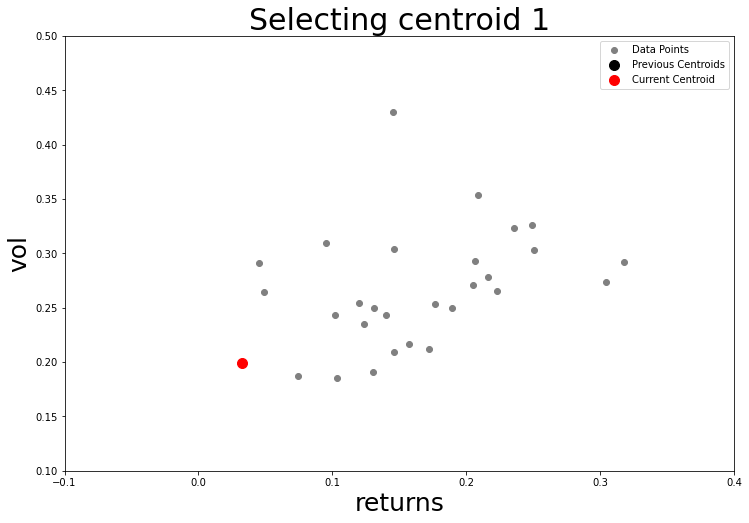

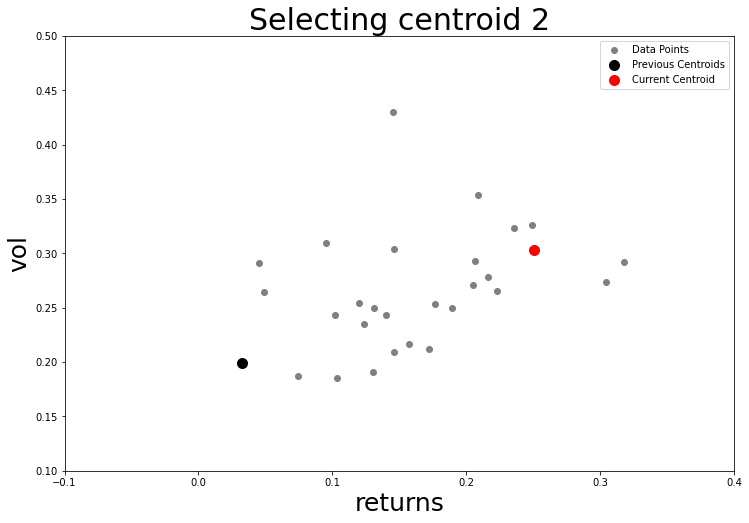

In [36]:
# Initialising centroids
centroids = InitCentroids(data,2)

In [37]:
# Performing K-Means Clustering
centroids2 = KMeansCluster(data,centroids,2)

The centroids are [[0.21955048222000834, 0.30110994193474727], [0.10804896177920095, 0.23288705368849666]]

Results achieved on iteration 3


## Now, we will plot our Voronoi Diagram with our initial set of centroids

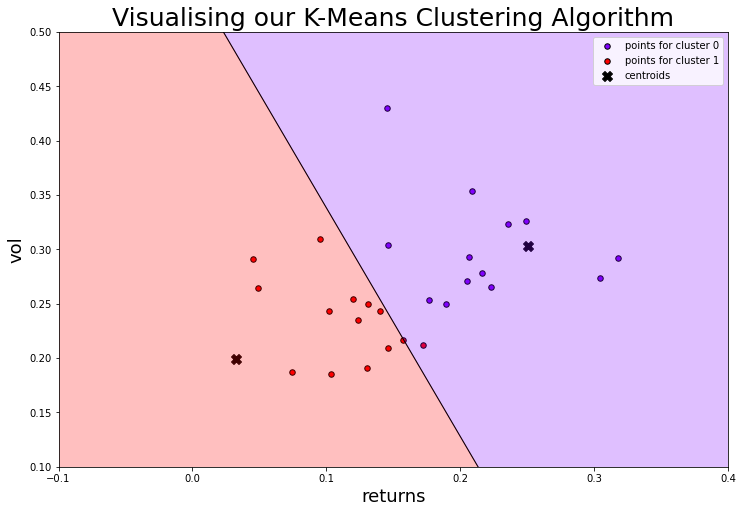

In [38]:
VoronoiPlot(data,centroids,2)

## To compare, we will now plot our Voronoi Diagram with our final set of centroids

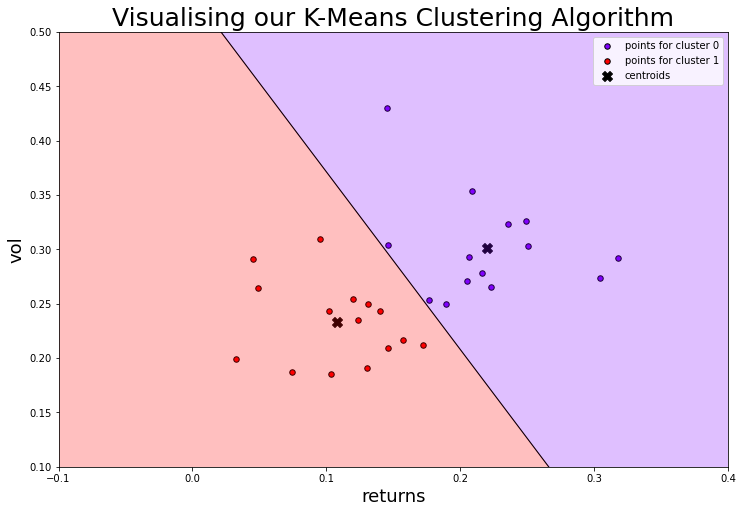

In [39]:
VoronoiPlot(data,centroids2,2)

## Finally, let us see our clustered data

In [40]:
data

,returns,vol,cluster
Ticker,,,
AAPL,0.317630,0.291758,0
AMGN,0.140286,0.243428,1
AMZN,0.248985,0.325859,0
AXP,0.235571,0.323047,0
BA,0.145530,0.430039,0
CAT,0.250569,0.303059,0
CRM,0.208482,0.353967,0
CSCO,0.119798,0.254593,1
CVX,0.146264,0.303783,0


In [41]:
# Print how many data points are in each cluster
number = []
for i in range(2):
    number.append(len(data[data['cluster']==i]))
    print("There are",number[i],f"data points in cluster {i}")

There are 14 data points in cluster 0
There are 15 data points in cluster 1


<h1><center> <ins><b> Dataset 4 - Real S&P500 Data</b></ins></center></h1>

In [42]:
# Call S&P500 stock data and calculate RSI and ATR (14 days)
# Get list of Stock Symbols to use for yfinance
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()
# Declare dates
end_date = '2025-02-01'
start_date = pd.to_datetime(end_date)-pd.DateOffset(50)
# Get stock data
df = yf.download(tickers=symbols_list,
                 auto_adjust = False,
                 start=start_date,
                 end=end_date).stack()
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()
# Calculate RSI
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=14))
# Calculate ATR
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())
df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)
df = df[['rsi','atr']]
# Date to cluster data
data = df.loc['2025-01-31']
# Scale data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, index=data.index, columns=data.columns)
# Remove outliers
data = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]
data.index.name = None
data.columns.name = None
data

[*********************100%***********************]  503 of 503 completed


,rsi,atr
A,1.235355,-0.020036
AAPL,-0.531421,1.096109
ABBV,1.096442,2.058883
ABNB,-0.431576,-0.115134
ABT,1.772907,0.255331
...,...,...
XYL,1.471517,0.876564
YUM,-0.124784,-1.266044
ZBH,0.078713,-0.640680
ZBRA,-0.912304,-0.121436


In [43]:
# Find the min and max values of each column for our plots later
xmin = data.iloc[:,:1].describe().iloc[3][0]
xmax = data.iloc[:,:1].describe().iloc[7][0]
ymin = data.iloc[:,1:2].describe().iloc[3][0]
ymax = data.iloc[:,1:2].describe().iloc[7][0]
xmin,ymin = (np.floor(x) for x in (xmin,ymin))
xmax,ymax = (np.ceil(x) for x in (xmax,ymax))

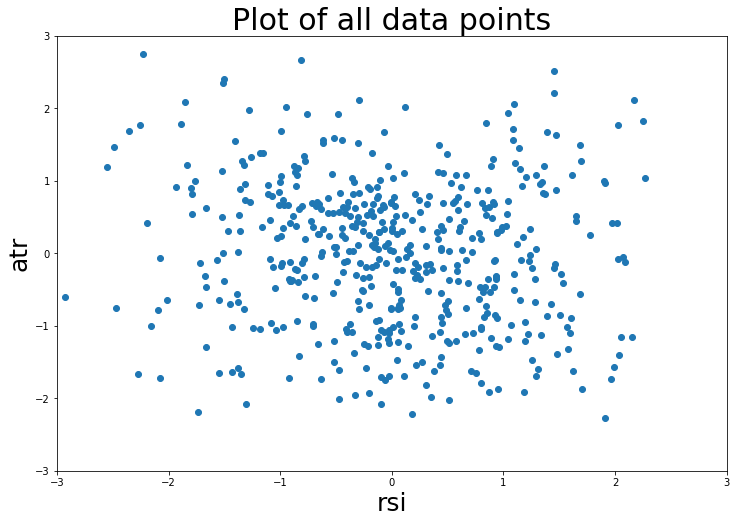

In [44]:
# Plot the data to see what we are working with
plt.figure(figsize=(12,8))
plt.scatter(data.iloc[:,:1], data.iloc[:,1:2], cmap='viridis', marker='o')
plt.xlabel(data.columns[0], fontsize=25)
plt.ylabel(data.columns[1], fontsize=25)
plt.title('Plot of all data points', fontsize=30)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

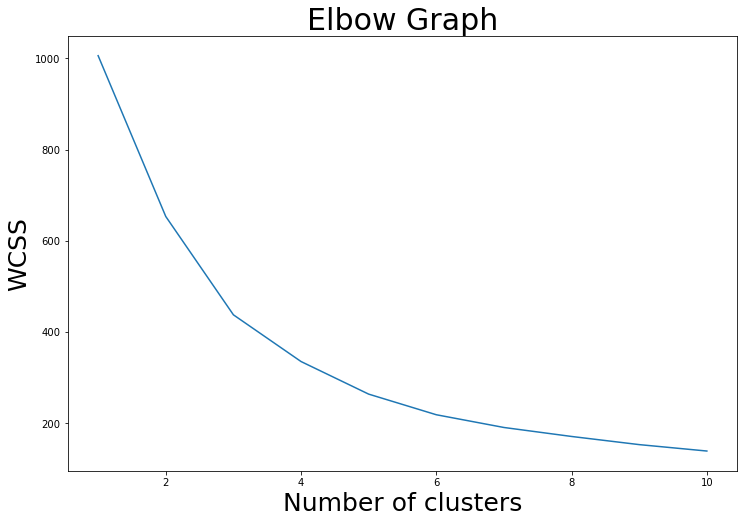

In [45]:
# Plotting Elbow Graph
ElbowGraph(data)

In [46]:
# Calculating Silhouette Scores
SilhouetteScore(data)

Silhouette score for k = 2 is 0.33289
Silhouette score for k = 3 is 0.35573
Silhouette score for k = 4 is 0.34277
Silhouette score for k = 5 is 0.30872
Silhouette score for k = 6 is 0.36127
Silhouette score for k = 7 is 0.34529
Silhouette score for k = 8 is 0.31675
Silhouette score for k = 9 is 0.33136
Silhouette score for k = 10 is 0.32710


## It is hard to tell solely by the initial plot of all data points nor our Elbow Graph, how many clusters there are. Yet when we look at our Silhouette Scores, we achieve our maximum at k=6. <br>Thus, let us continue with k=6

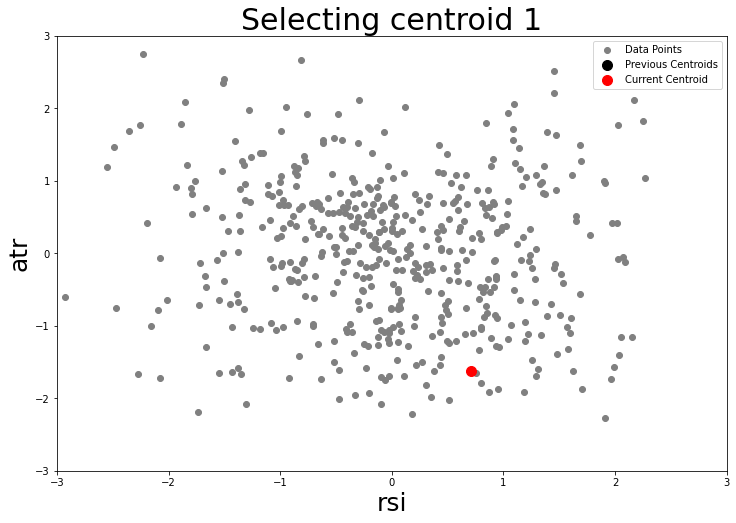

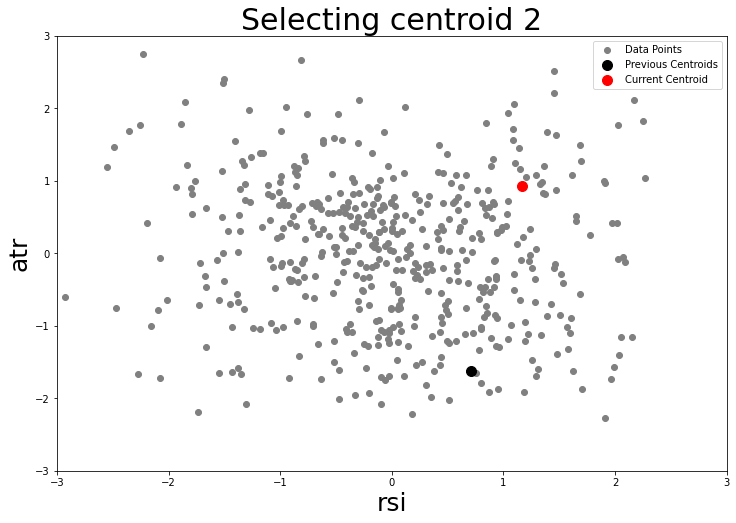

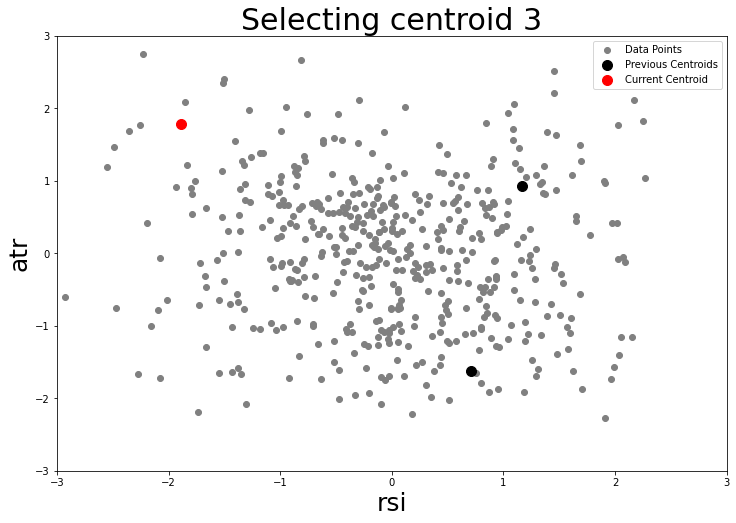

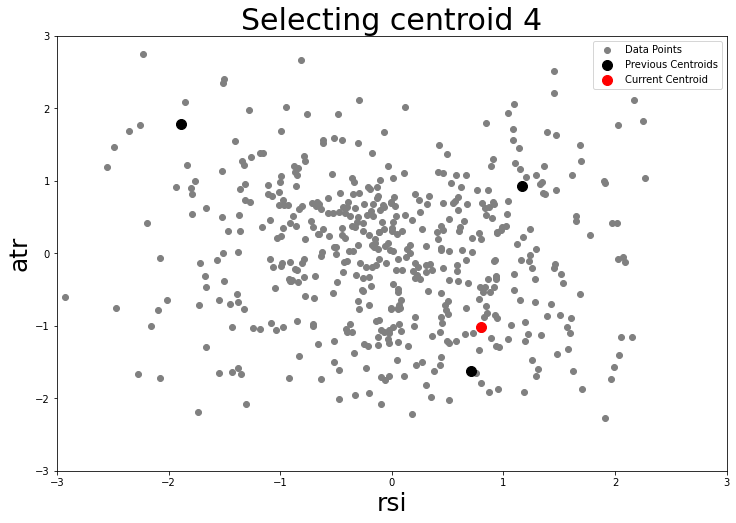

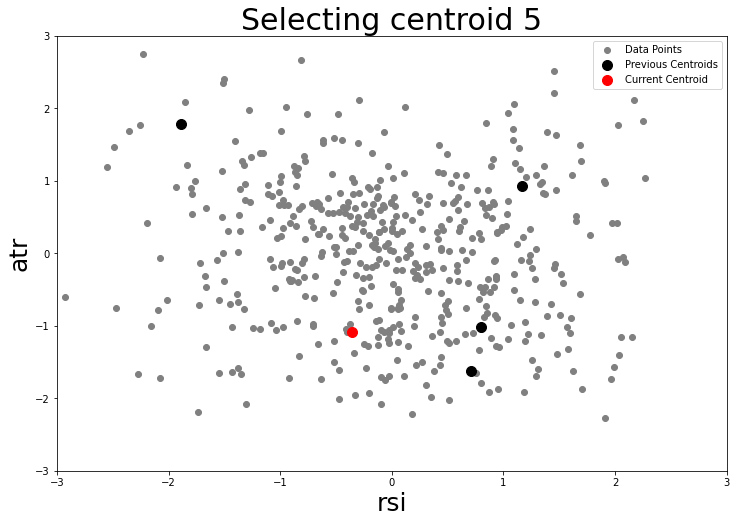

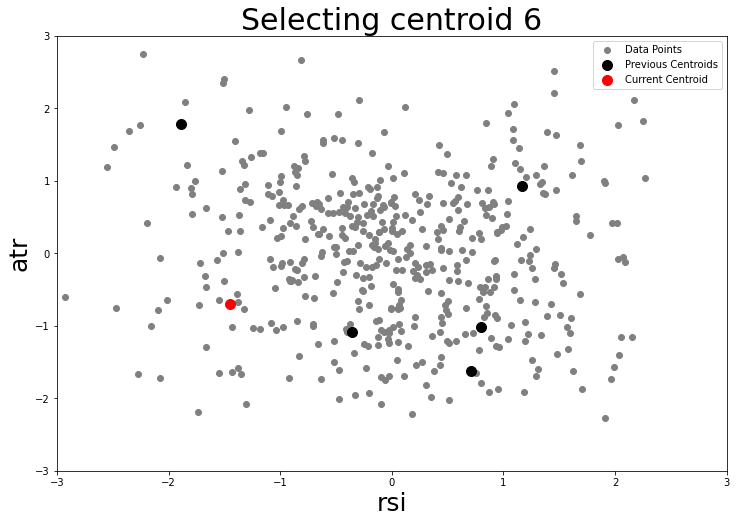

In [47]:
# Initialising centroids
centroids = InitCentroids(data,6)

In [48]:
# Performing K-Means Clustering
centroids2 = KMeansCluster(data,centroids,6)

The centroids are [[-1.127341569669156, 1.1131648897348552], [1.1274349643540593, 0.9879207815261354], [-1.3074372777795416, -0.740225919261142], [1.2507920805859267, -0.8008533622512815], [-0.06577255722541804, 0.24004016444569562], [0.09733042220261888, -1.243678006604724]]

Results achieved on iteration 12


## Now, we will plot our Voronoi Diagram with our initial set of centroids

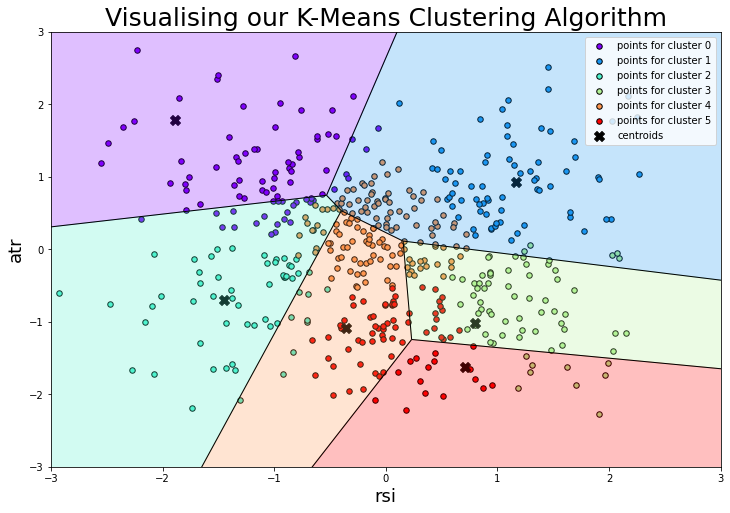

In [49]:
VoronoiPlot(data,centroids,6)

## To compare, we will now plot our Voronoi Diagram with our final set of centroids

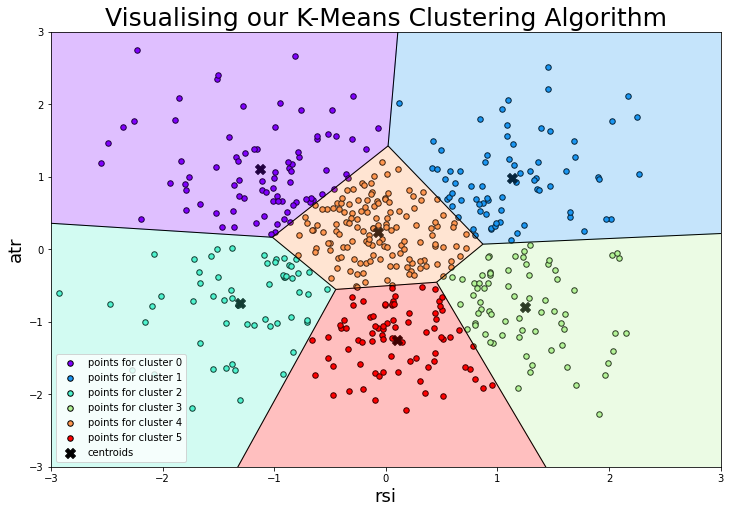

In [50]:
VoronoiPlot(data,centroids2,6)

## Finally, let us see our clustered data

In [51]:
data

,rsi,atr,cluster
A,1.235355,-0.020036,3
AAPL,-0.531421,1.096109,0
ABBV,1.096442,2.058883,1
ABNB,-0.431576,-0.115134,4
ABT,1.772907,0.255331,1
...,...,...,...
XYL,1.471517,0.876564,1
YUM,-0.124784,-1.266044,5
ZBH,0.078713,-0.640680,5
ZBRA,-0.912304,-0.121436,2


In [52]:
# Print how many data points are in each cluster
number = []
for i in range(6):
    number.append(len(data[data['cluster']==i]))
    print("There are",number[i],f"data points in cluster {i}")

There are 82 data points in cluster 0
There are 73 data points in cluster 1
There are 58 data points in cluster 2
There are 70 data points in cluster 3
There are 141 data points in cluster 4
There are 79 data points in cluster 5


### We may look at our clustering of stocks, and decide to spread our portfolio across all clusters to ensure that risk is lowered and potential long-term returns increase.